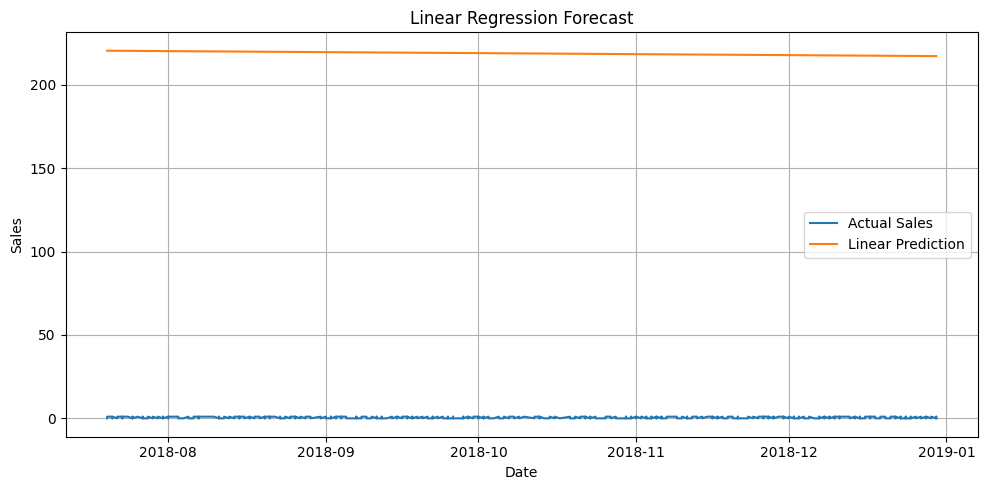

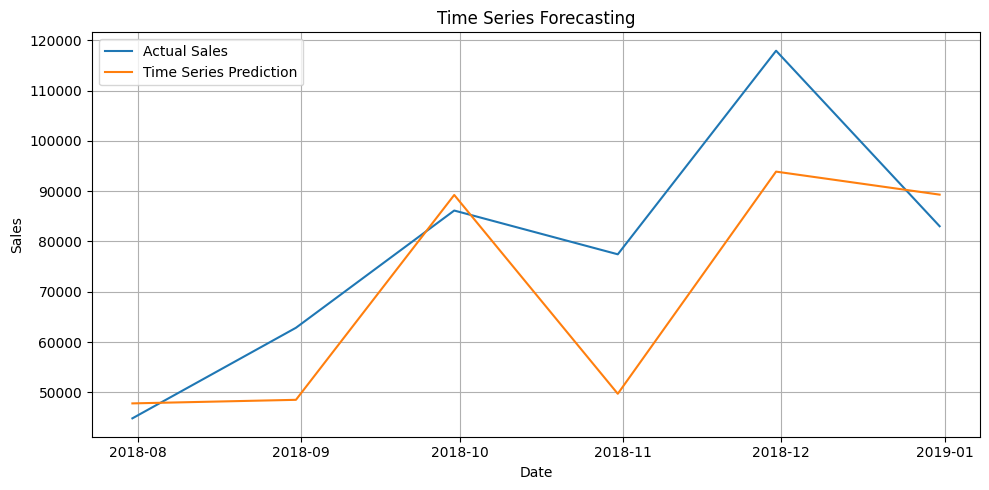


🔍 Forecasting Accuracy Comparison:
                 Model          RMSE           MAE        R2  Accuracy (Log)
0    Linear Regression    590.566623    261.692060 -0.000132             NaN
1  Logistic Regression           NaN           NaN       NaN        0.496939
2          Time Series  16385.602283  13078.476779  0.465627             NaN


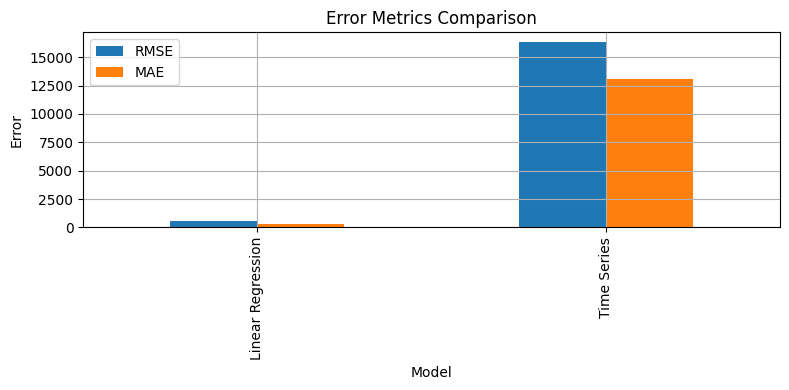

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load dataset
data = pd.read_csv('/content/train.csv')  # replace with your path

# Convert Order Date
data['Order Date'] = pd.to_datetime(data['Order Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Order Date'])  # remove rows with invalid dates
data = data.sort_values('Order Date')

# -----------------------------
# LINEAR REGRESSION
# -----------------------------
data['Order_Ordinal'] = data['Order Date'].map(pd.Timestamp.toordinal)

X = data[['Order_Ordinal']]
y = data['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

# -----------------------------
# LOGISTIC REGRESSION
# -----------------------------
# Convert Sales to binary class (e.g. 1 = high sale, 0 = low sale)
threshold = data['Sales'].median()
data['Sales_Class'] = (data['Sales'] > threshold).astype(int)

X = data[['Order_Ordinal']]
y = data['Sales_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

acc_log = accuracy_score(y_test, y_pred_log)

# -----------------------------
# TIME SERIES FORECASTING
# -----------------------------
monthly_sales = data.set_index('Order Date').resample('M').sum()['Sales']

ts_train = monthly_sales.iloc[:-6]
ts_test = monthly_sales.iloc[-6:]

model = ExponentialSmoothing(ts_train, trend='add', seasonal='add', seasonal_periods=12)
fit_model = model.fit()
ts_pred = fit_model.forecast(6)

rmse_ts = np.sqrt(mean_squared_error(ts_test, ts_pred))
mae_ts = mean_absolute_error(ts_test, ts_pred)
r2_ts = r2_score(ts_test, ts_pred)

# -----------------------------
# PLOTS & COMPARISONS
# -----------------------------
# Linear Regression Plot
plt.figure(figsize=(10, 5))
plt.plot(data['Order Date'].iloc[-len(y_test):], y_test, label='Actual Sales')
plt.plot(data['Order Date'].iloc[-len(y_test):], y_pred_lin, label='Linear Prediction')
plt.title('Linear Regression Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Time Series Forecast Plot
plt.figure(figsize=(10, 5))
plt.plot(ts_test.index, ts_test.values, label='Actual Sales')
plt.plot(ts_test.index, ts_pred.values, label='Time Series Prediction')
plt.title('Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Error Comparison
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Logistic Regression', 'Time Series'],
    'RMSE': [rmse_lin, None, rmse_ts],
    'MAE': [mae_lin, None, mae_ts],
    'R2': [r2_lin, None, r2_ts],
    'Accuracy (Log)': [None, acc_log, None]
})

print("\n🔍 Forecasting Accuracy Comparison:")
print(metrics_df)

# Plot RMSE & MAE
metrics_df_plot = metrics_df.drop(columns=['R2', 'Accuracy (Log)']).set_index('Model').dropna()

metrics_df_plot.plot(kind='bar', figsize=(8, 4), title='Error Metrics Comparison', ylabel='Error')
plt.grid(True)
plt.tight_layout()
plt.show()
